## Importação de Bibliotecas

In [1]:
# Python versão 3.8.8
# Windows 10

# biblioteca para interação com o sistema
import os
import shutil

# biblioteca para manipulação de dados
import pandas as pd # versão 1.3.2
import numpy as np

# biblioteca para manipulação de banco de dados sqlite
import sqlite3 # versão 2.6.0
from sqlite3 import Error

import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier # Importa o classificador de árvore de decisão
from sklearn import metrics #Importa métrica para calcular acurácia - módulo do scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold  
from IPython.display import Image  

In [3]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

In [4]:
from sklearn.metrics import classification_report

## Variáveis Globais

In [5]:
path_atual = os.path.dirname(os.path.realpath('__file__')) + "\\" # diretório onde se encontra o script
nome_bd = "COVID_MG_DW.sqlite"

## Conexão Banco de Dados

In [6]:
def nova_conexao(path, nome_bd):

    conec_bd = None
    try:
        conec_bd = sqlite3.connect(path + nome_bd)

    except Error as erro:
        print(erro)
        return 0
    
    finally:
        if conec_bd:
            conec_bd.close()
    return 1

In [7]:
if (nova_conexao(path_atual,  nome_bd)):
    conec_bd = sqlite3.connect(path_atual + nome_bd)
    cursor = conec_bd.cursor()
    print("Conexão ao banco '{}' criada com sucesso.".format(nome_bd))
    conec_bd.commit()

Conexão ao banco 'COVID_MG_DW.sqlite' criada com sucesso.


## Leitura de Dados

In [8]:
dim_municipio = pd.read_sql_query("SELECT * FROM Dim_Municipio", conec_bd)
dim_tempo = pd.read_sql_query("SELECT * FROM Dim_Tempo", conec_bd)
dim_paciente = pd.read_sql_query("SELECT * FROM Dim_Paciente", conec_bd)
dim_status_tratamento = pd.read_sql_query("SELECT * FROM Dim_Status_Tratamento", conec_bd)
fato_internacao = pd.read_sql_query("SELECT * FROM Fato_Internacao", conec_bd)

In [9]:
dim_tempo.ID_TEMPO = pd.to_datetime(dim_tempo.ID_TEMPO)
fato_internacao.ID_TEMPO = pd.to_datetime(fato_internacao.ID_TEMPO)
dim_tempo["Ano"] = dim_tempo.ID_TEMPO.dt.year
dim_tempo["Mes"] = dim_tempo.ID_TEMPO.dt.month

In [10]:
base_dados =  pd.merge(fato_internacao, dim_paciente, how="inner", on=["ID_PESSOA"])
base_dados =  pd.merge(base_dados, dim_status_tratamento, how="inner", on=["ID_PESSOA"])
base_dados =  pd.merge(base_dados, dim_municipio, how="inner", on=["ID_MUNICIPIO"])
base_dados =  pd.merge(base_dados, dim_tempo, how="inner", on=["ID_TEMPO"])

In [11]:
base_dados = base_dados.sort_values(by = "ID_TEMPO")

## Funções

In [12]:
# Função para gerar a árvore
def geraArvore(clf, Xone_hot_data, nome):
  
    feature_names = Xone_hot_data.columns # precisa receber o nome das colunas do dataset completo que nesse caso é o "Xone_hot_data"
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names, class_names=['0', '1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('arvore' + nome + '.png')
    arvore = graph.create_png()

    return arvore  # retorna a arvore com uma imagem png

In [13]:

def arvoreDecisao(Xone_hot_data,tamanho_train, criterio = "None", min_samples_split = 2, max_depth = None, shuffleAtiv = False):
  
    global X_treino, X_teste, Y_treino, Y_teste
    
    X_treino, X_teste, Y_treino, Y_teste = train_test_split(Xone_hot_data, y,
                                                        train_size = tamanho_train, shuffle=shuffleAtiv)

    # se o tamanho de treinamento for 1, siginifica que todos os dados serão utilizados para treinamento
    if (tamanho_train == 1):

        X_treino, X_teste, Y_treino, Y_teste = train_test_split(Xone_hot_data, y,
                                                            test_size = 0.2, shuffle=shuffleAtiv)

        X_treino = Xone_hot_data # o treimento recebe todo o dataset
        Y_treino = y


    if (criterio):
        # Criação do classificador de árvore de decisão utilizando entropy ou gini
        clf = DecisionTreeClassifier(criterion = criterio, min_samples_split = min_samples_split, max_depth = max_depth)

    else:
        # Se nenhum parâmetro for passado, utiliza-se o default que é gini
        clf = DecisionTreeClassifier(min_samples_split, max_depth)

    # Método para construir o classificador a partir do conjunto de treinamento
    clf1 = clf.fit(X_treino, Y_treino)

    return clf1
  

## Modelo I

In [14]:
base_dados.head(3)

,ID_PESSOA,ID_MUNICIPIO,ID_TEMPO,GENERO,IDADE,FAIXA_ETARIA,DIAS_PRA_NOTIFICACAO,EVOLUCAO,INTERNACAO,UTI,MUNICIPIO_RESIDENCIA,MICRO,URS,MACRO,POPULAÇÃO_ESTIMADA,PIB_PER_CAPITA,Dia,Mes,Ano
964809,31803,311860,2020-01-01,FEMININO,58,50 A 59 ANOS,0,RECUPERADO,SIM,NAO,CONTAGEM,CONTAGEM,BELO HORIZONTE,CENTRO,673849,42077.02,1,1,2020
964850,379672,315700,2020-01-04,MASCULINO,0,<1ANO,0,RECUPERADO,NAO,NAO,SALINAS,SALINAS,MONTES CLAROS,NORTE,41864,13184.48,4,1,2020
964849,352192,314390,2020-01-04,FEMININO,32,30 A 39 ANOS,0,RECUPERADO,NAO,NAO,MURIAE,MURIAE,UBA,SUDESTE,109997,19884.40,4,1,2020


In [15]:
dataset = base_dados.copy()

In [16]:
dados_macro = dataset.drop_duplicates(subset = "MUNICIPIO_RESIDENCIA").reset_index()
dados_populacao_macro = dados_macro.groupby(["MACRO"])["POPULAÇÃO_ESTIMADA"].sum().to_frame("POPULACAO_MACRO")
dados_pib_macro = dados_macro.groupby(["MACRO"])["PIB_PER_CAPITA"].mean().to_frame("PIB_PER_CAPITA_MACRO")

dados_macro = dados_populacao_macro.join(dados_pib_macro)
dados_macro = dados_macro.reset_index()

In [17]:
dataset = pd.merge(dataset, dados_macro, how="left", on=["MACRO"])

In [18]:
# # dataset.drop(['IDADE'], axis=1, inplace=True)
# dataset.drop(['ID_PESSOA'],axis=1,  inplace=True)
# dataset.drop(['ID_MUNICIPIO'],axis=1,  inplace=True)
# dataset.drop(['ID_TEMPO'],axis=1,  inplace=True)
# dataset.drop(['MICRO'],axis=1,  inplace=True)
# dataset.drop(['URS'],axis=1,  inplace=True)
# dataset.drop(['MUNICIPIO_RESIDENCIA'],axis=1,  inplace=True)
# # dataset.drop(['MACRO'],axis=1,  inplace=True)
# dataset.drop(['POPULAÇÃO_ESTIMADA'],axis=1,  inplace=True)
# dataset.drop(['PIB_PER_CAPITA'],axis=1,  inplace=True)
# dataset.drop(['Dia'],axis=1,  inplace=True)

In [19]:
dataset.INTERNACAO = np.where(dataset.INTERNACAO == "SIM", 1, 0)
dataset.UTI = np.where(dataset.UTI == "SIM", 1, 0)
dataset.EVOLUCAO = np.where(dataset.EVOLUCAO == "OBITO", 1, 0)

In [20]:
dataset = dataset.rename(columns = {"EVOLUCAO": "OBITO"})

In [21]:
dataset.head(3)

,ID_PESSOA,ID_MUNICIPIO,ID_TEMPO,GENERO,IDADE,FAIXA_ETARIA,DIAS_PRA_NOTIFICACAO,OBITO,INTERNACAO,UTI,...,MICRO,URS,MACRO,POPULAÇÃO_ESTIMADA,PIB_PER_CAPITA,Dia,Mes,Ano,POPULACAO_MACRO,PIB_PER_CAPITA_MACRO
0,31803,311860,2020-01-01,FEMININO,58,50 A 59 ANOS,0,0,1,0,...,CONTAGEM,BELO HORIZONTE,CENTRO,673849,42077.02,1,1,2020,6727252,27503.078911
1,379672,315700,2020-01-04,MASCULINO,0,<1ANO,0,0,0,0,...,SALINAS,MONTES CLAROS,NORTE,41864,13184.48,4,1,2020,1700450,10960.377326
2,352192,314390,2020-01-04,FEMININO,32,30 A 39 ANOS,0,0,0,0,...,MURIAE,UBA,SUDESTE,109997,19884.40,4,1,2020,1693470,15323.150000


In [22]:
atributosNumer = ['DIAS_PRA_NOTIFICACAO','PIB_PER_CAPITA_MACRO','Dia','Mes','Ano','INTERNACAO','UTI', 'IDADE'] # atributos numéricos
atributosCateg = ['GENERO'] # atributos categóricos

dataset_dummies = pd.get_dummies(dataset[atributosCateg]) # subdividindo as colunas categóricas em numéricas

dataset_dummies.head(3)

,GENERO_FEMININO,GENERO_MASCULINO
0,1,0
1,0,1
2,1,0


In [23]:
y = dataset.OBITO
dataset_modelo = pd.concat([dataset_dummies, dataset[atributosNumer]], axis=1, join="inner")

In [24]:
clf =  arvoreDecisao(dataset_modelo, 0.9, criterio = "entropy", shuffleAtiv = False, max_depth = 6)

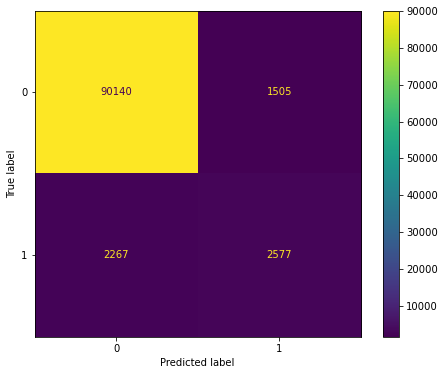

In [40]:
plot_confusion_matrix(clf,  X_teste, Y_teste, values_format = '.0f')  
plt.show()
plt.rcParams["figure.figsize"] = (40,7)

In [26]:
Y_pred = clf.predict(X_teste)

In [27]:
print(classification_report(Y_teste, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     91645
           1       0.63      0.53      0.58      4844

    accuracy                           0.96     96489
   macro avg       0.80      0.76      0.78     96489
weighted avg       0.96      0.96      0.96     96489



In [28]:
acuracia = metrics.accuracy_score(Y_teste, Y_pred)
print(f"A Acurácia do modelo é de: {acuracia}")

A Acurácia do modelo é de: 0.9609074609540984


In [29]:
precisao = metrics.precision_score(Y_teste, Y_pred)
print(f"A Precisão do modelo é de: {precisao}")

A Precisão do modelo é de: 0.6313081822635963


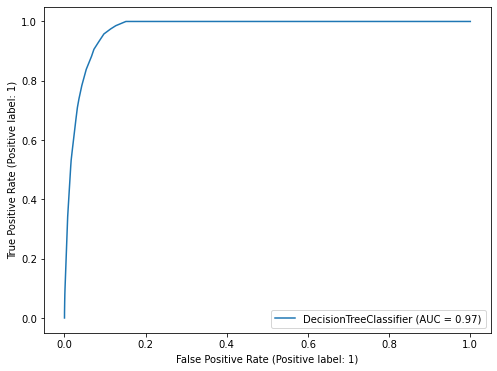

In [30]:
plt.rcParams["figure.figsize"] = (8,6)
metrics.plot_roc_curve(clf,  X_teste, Y_teste) 

## Modelo Floresta

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(dataset_modelo, y,
                                                        train_size = 0.9, shuffle = False)

In [43]:
clf_rf = RandomForestClassifier(n_estimators=10, criterion = "entropy",  max_depth = 6)

clf_rf.fit(X_treino, Y_treino)

RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=10)

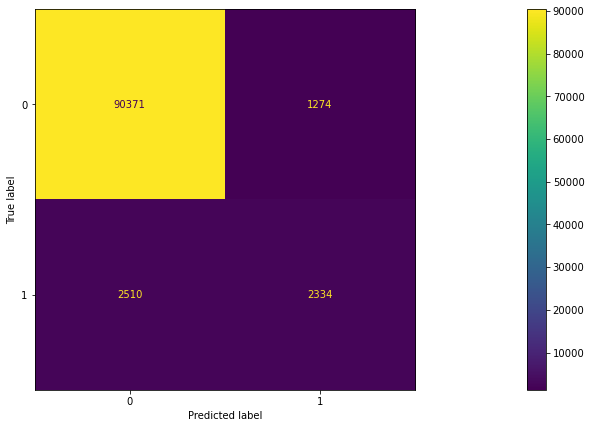

In [44]:
plot_confusion_matrix(clf_rf,  X_teste, Y_teste, values_format = '.0f')  
plt.show()
plt.rcParams["figure.figsize"] = (40,7)

In [45]:
Y_pred_rf = clf_rf.predict(X_teste)

In [46]:
print(classification_report(Y_teste, Y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     91645
           1       0.65      0.48      0.55      4844

    accuracy                           0.96     96489
   macro avg       0.81      0.73      0.77     96489
weighted avg       0.96      0.96      0.96     96489



In [47]:
acuracia = metrics.accuracy_score(Y_teste, Y_pred_rf)
print(f"A Acurácia do modelo é de: {acuracia}")

A Acurácia do modelo é de: 0.9607830944459991


In [48]:
precisao = metrics.precision_score(Y_teste, Y_pred_rf)
print(f"A Precisão do modelo é de: {precisao}")

A Precisão do modelo é de: 0.6468957871396895


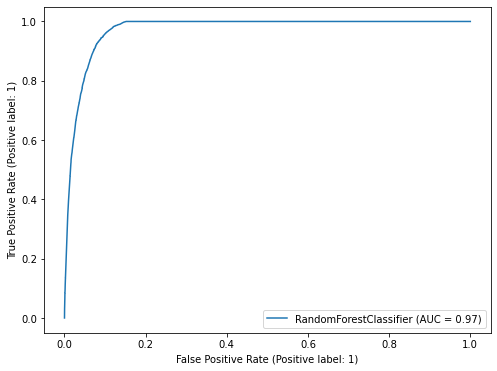

In [49]:
plt.rcParams["figure.figsize"] = (8,6)
metrics.plot_roc_curve(clf_rf,  X_teste, Y_teste) 